In [1]:
from scipy.io import netcdf, loadmat
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from IPython.display import display, Math, Latex
from python_functions import *
sys.path.append('/noc/users/am8e13/Python/sfepy/')
import sfepy

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def grad_calc(Depth, hfacc, dxF, dyF, X, Y, Z, res): 
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[1,x])
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dyF[y+1,x]-dyF[0,x])
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[0,x])
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+2,x]-dyF[y,x])
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
                
    return Sx,Sy

def grid(res):
    if res == 18:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results18km/grid.nc",'r')
        nx = 420
        ny = 384
        k = 2
        
    elif res == 9:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results9km/grid.nc",'r')
        nx = 840
        ny = 768
        k = 4
        
    elif res == 36:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results36km/grid.nc",'r')
        nx = 210
        ny = 192
        k = 1
        
    Depth = file2read.variables['Depth']
    Depth = Depth[:]*1
    hfacc=file2read.variables['HFacC']
    hfacc=hfacc[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    X = file2read.variables['X']
    X = X[:]*1
    Y = file2read.variables['Y']
    Y = Y[:]*1
    Z = file2read.variables['Z']
    Z = Z[:]*1
    
    return Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k
    

In [3]:
def grad_calc_mod(Depth, hfacc, dxF, dyF, X, Y, Z, res): 
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    
    dx = res*1000
    dy = res*1000
    
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dy)
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dy)
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dy)
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dy)
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dy)
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            
    return Sx,Sy
                

In [4]:
def equations(res):
    
    Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(res)
    
    dt = 0.1 #600
    dx = 100
    dy = 100
    
    # Calculating matrix:
    #  (-1 1 . . . . . 0 0 0 )
    #  (0 -1 1 . . . . . . 0 )
    #  (0 0 -1 1 . . . 0 0 0 )
    #  .........
    #  (0 0 0 0 0 0 0 0 0 0-1 )

    id_y = np.zeros((ny,ny))
    for i in range(1,ny-1):
        id_y[i,i-1] = -dt/(2*dx)
        id_y[i,i+1] = dt/(2*dx)

    # Calculating matrix:
    #  (-1 0 0 . . . . . 0 0 0 )
    #  (1 -1 0 0 . . . . . . 0 )
    #  (0 1 -1 0 1 . . . 0 0 0 )
    #  (0 0  1  .....    1 -1 0 )
    #  ( . . . . . . . . . 1 0 )
    #  (0 0 1 0 0 0 0 0 0 0 -1 )

    id_x = np.zeros((nx,nx))
    for i in range(1,nx-1):
        id_x[i-1,i] = -dt/(2*dx)
        id_x[i+1,i] = dt/(2*dx)

    diff_x = np.zeros_like(id_x)
    diff_y = np.zeros_like(id_y)
    err = 1
    for j in range(1,nx-1,1):
        diff_x[j+1,j] = dt/(2*dx)*err
        diff_x[j-1,j] = dt/(2*dx)*err
        diff_x[j,j] = -dt/(dx)*err

    for j in range(1,ny-1,1):
        diff_y[j+1,j] = dt/(2*dx)*err
        diff_y[j-1,j] = dt/(2*dx)*err
        diff_y[j,j] = -dt/(dx)*err
    
    Sx,Sy = grad_calc_mod(Depth, hfacc, dxF, dyF, X, Y, Z, res)    
    Sy[Sy>20]=20
    Sy[Sy<-20]=-20
    Sx[Sx>20]=20
    Sx[Sx<-20]=-20
    
    S0 = S0 = np.zeros_like(Sx)
    S0[70*k:80*k,34*k:42*k] = 10
    
    U = np.zeros_like(S0)
    U[:,:] = 20
    V = np.zeros_like(S0)
    V[:,:] = 20
    
    return Sx,Sy,id_x,id_y,diff_x,diff_y,S0,U,V,hfacc
Sx,Sy,id_x,id_y,diff_x,diff_y,S0,U,V,hfacc = equations(36)

<matplotlib.colorbar.Colorbar instance at 0x2ad96af43b48>

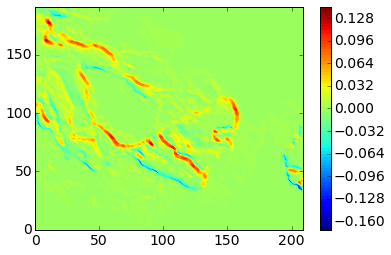

In [5]:
plt.contourf(Sx + Sy,100)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ad96b63f518>

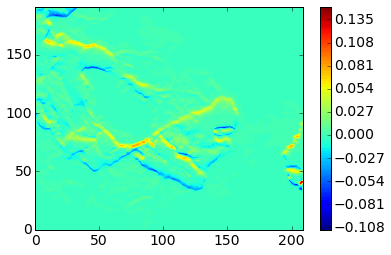

In [6]:
plt.contourf(Sy,100)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ad96b9c3cf8>

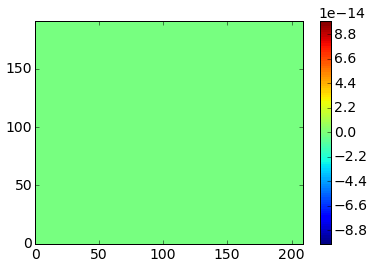

In [12]:
Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(36)

Depth1 = np.zeros_like(Depth)
for xx in range(len(X)):
    for yy in range(len(Y)):
        #Depth1[yy,xx] = (xx - len(X)/2)**2 + (yy - len(Y)/2)**2
        Depth1[yy,xx] = np.abs(xx - len(X)/2)
Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(36)
Sx2,Sy2 = grad_calc_mod(Depth1, hfacc, dxF, dyF, X, Y, Z, 36)
#plt.contourf(Depth1,100)
#plt.contourf(Sx2,100)
plt.contourf(Sy2,100)
plt.colorbar()


In [221]:
S1 = np.array(S0)
S2 = np.array(S0)
S3 = np.array(S0)
S4 = np.array(S0)

nt = 1000
vel = 10000
Sx2_touse = Sx2*vel
Sy2_touse = Sy2*vel
diff1 = np.zeros([nt,1])
diff2 = np.zeros([nt,1])

for i in range(0,nt):
    #print U.shape,V.shape,id_x.shape,id_y.shape
    
    for x in range(S1.shape[0]):
        S1[x,:] = S1[x,:] + np.dot(id_x*Sx2_touse[x,:],S1[x,:]) + np.dot(diff_x,S1[x,:]) 
    for y in range(S1.shape[1]):
        S2[:,y] = S2[:,y] + np.dot(id_y*Sy2_touse[:,y],S2[:,y]) + np.dot(diff_y,S2[:,y]) 
        
    S3 = S3 + np.multiply(S3.T,np.dot(id_x,Sx2_touse.T)).T + np.dot(diff_x,S3.T).T
    S4 = S4 + np.multiply(S4,np.dot(id_y,Sy2_touse)) + np.dot(diff_y,S4)
    
    
    diff1[i] = sum(sum(abs(S1-S3)))
    diff2[i] = sum(sum(abs(S2-S4)))

KeyboardInterrupt: 

<matplotlib.contour.QuadContourSet instance at 0x2b27a4ab7b00>

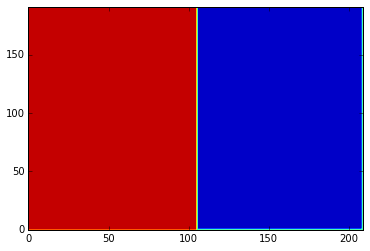

In [254]:
plt.contourf(Sx2_touse)

In [ ]:
S1 = np.array(S0)
S2 = np.array(S0)
S3 = np.array(S0)
S4 = np.array(S0)
S5 = np.array(S0)

nt = 1000
vel = 100000
Sx2_touse = Sx2*vel
Sy2_touse = Sy2*vel
diff1 = np.zeros([nt,1])
diff2 = np.zeros([nt,1])
diff3 = np.zeros([nt,1])

Sx_comb = np.ndarray([192,210,210])
for x in range(S1.shape[0]):
    Sx_comb[x,:,:] = id_x*Sx2_touse[x,:]

for i in range(0,nt*100):
    #print U.shape,V.shape,id_x.shape,id_y.shape
    
    for x in range(S1.shape[0]):
        S1[x,:] = S1[x,:] + np.dot(id_x*Sx2_touse[x,:],S1[x,:])
        S3[x,:] = S3[x,:] + np.dot(id_x*Sx2_touse[x,:],S3[x,:])
    for y in range(S1.shape[1]):
        S2[:,y] = S2[:,y] + np.dot(id_y*Sy2_touse[:,y],S2[:,y]) 
        S3[:,y] = S3[:,y] + np.dot(id_y*Sy2_touse[:,y],S3[:,y]) 
        
    #S3 = S3 + np.multiply(S3.T,np.dot(id_x,Sx2_touse.T)).T
    S5 = S5 + np.multiply(np.dot(Sx2_touse,id_x),S5)
    S4 = S4 + np.multiply(S4,np.dot(id_y,Sy2_touse))
    
    
    #diff1[i] = sum(sum(abs(S1-S3)))
    #diff2[i] = sum(sum(abs(S2-S4)))
    #diff3[i] = sum(sum(abs(S5-S3)))

In [14]:
S1 = np.array(S0)
vel = 100
Sx2_touse = Sx2*vel
Sx_comb = np.ndarray([192,210,210])
for x in range(S1.shape[0]):
    Sx_comb[x,:,:] = id_x*Sx2_touse[x,:]
    
for i in range(10):
    for x in range(S1.shape[0]):
        S1[x,:] = S1[x,:] + np.dot(Sx_comb[x,:,:],S1[x,:])

In [37]:
np.matmul(Sx_comb[:,:,:],S1[:,:], axes=([0,1,2],[0,1]))

AttributeError: 'module' object has no attribute 'matmul'

In [33]:
help(np.tensordot)

Help on function tensordot in module numpy.core.numeric:

tensordot(a, b, axes=2)
    Compute tensor dot product along specified axes for arrays >= 1-D.
    
    Given two tensors (arrays of dimension greater than or equal to one),
    `a` and `b`, and an array_like object containing two array_like
    objects, ``(a_axes, b_axes)``, sum the products of `a`'s and `b`'s
    elements (components) over the axes specified by ``a_axes`` and
    ``b_axes``. The third argument can be a single non-negative
    integer_like scalar, ``N``; if it is such, then the last ``N``
    dimensions of `a` and the first ``N`` dimensions of `b` are summed
    over.
    
    Parameters
    ----------
    a, b : array_like, len(shape) >= 1
        Tensors to "dot".
    axes : variable type
        * integer_like scalar
          Number of axes to sum over (applies to both arrays); or
        * (2,) array_like, both elements array_like of the same length
          List of axes to be summed over, first sequence 

<matplotlib.colorbar.Colorbar instance at 0x2b27bb9899e0>

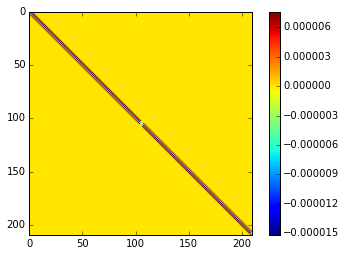

In [330]:
plt.imshow(np.dot(Sx_comb[190,:,:],S1[190,:]))
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b27a40fafc8>

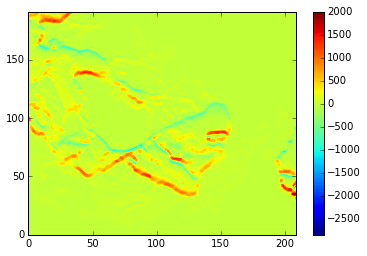

In [291]:
grad = np.array(np.gradient(Depth))
plt.contourf(grad[0,:,:],100)
plt.colorbar()

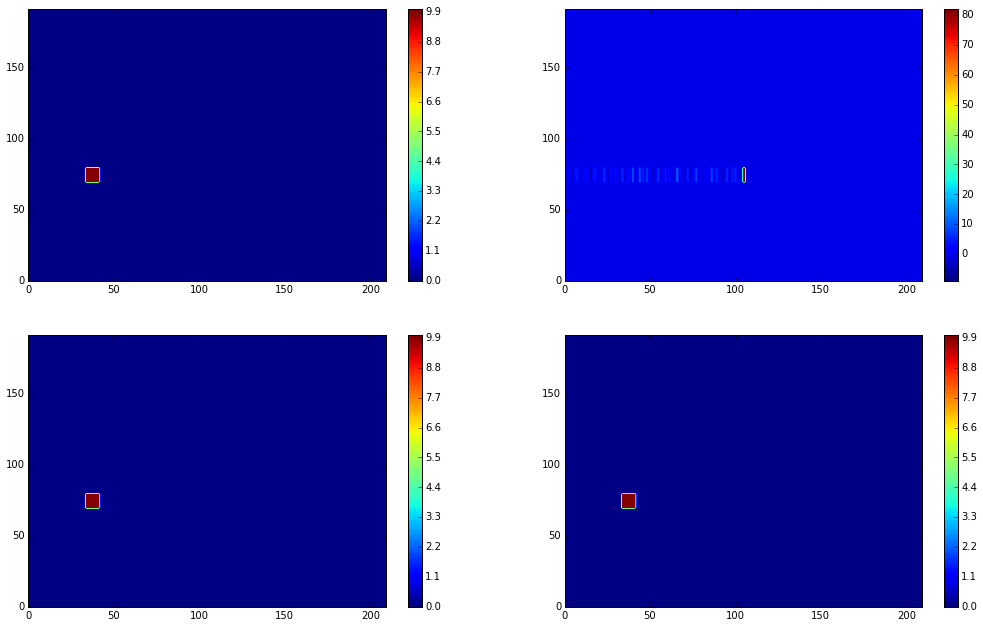

In [263]:
#S[hfacc[0,:,:]==0]=np.nan
S00 = np.array(S0)
#S00[hfacc[0,:,:]==0]=np.nan
fig, axes = plt.subplots(2,2)
a0 = axes[0,0].contourf(S00,100)
cbar = fig.colorbar(a0 , ax=axes[0,0])
#S1[hfacc[0,:,:]==0]=np.nan
a1 = axes[0,1].contourf(S1,100)
cbar = fig.colorbar(a1 , ax=axes[0,1])
#S2[hfacc[0,:,:]==0]=np.nan
a2 = axes[1,0].contourf(S2,100)
cbar = fig.colorbar(a2 , ax=axes[1,0])
#S3[hfacc[0,:,:]==0]=np.nan
a3 = axes[1,1].contourf(S5,100)
cbar = fig.colorbar(a3 , ax=axes[1,1])

fig.subplots_adjust(right=2.4,top=2.2)

In [6]:
def nangrid(field,res):
    ### This script fills the field with nans in the right bit
    if res == 18:
        x="/scratch/general/am8e13/results18km/"        
        nx = 420
        ny = 384 
    elif res == 36:
        x="/scratch/general/am8e13/results36km/"
        nx = 210
        ny = 192
    file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    
    if len(field.shape) == 4 :
        field[:,hfacc == 0] = np.nan
    elif len(field.shape) == 3 :
        field[hfacc == 0] = np.nan
    elif len(field.shape) == 2 :
        field[hfacc[0,:,:] == 0] = np.nan
    
    return field

In [7]:
x="/scratch/general/am8e13/results18km/"        
file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
hfacc = file2read.variables['HFacC']
hfacc = hfacc[:]*1

In [8]:
## 1 D version of the advection equation

In [156]:
dt = 0.00001
dx = 1

def S0(x):
    if x > 100
S_1d = np.zeros(200)
S_1d[40:60]=10
S_1d[90:110]=10
S_1d[140:160]=10
V_1d = np.zeros_like(S_1d)
for x in range(200):
    V_1d[x]= (x - 200/2)*10

V_1d[:] = -1000
    
id_1d = np.zeros((200, 200))
for j in range(0,198,1):
    id_1d[j+1,j] = dt/dx*V_1d[j+1]
    id_1d[j,j] = -dt/dx*V_1d[j]
id_1d[199,199]=-dt/dx*V_1d[j]


id_2o_1d = np.zeros((200, 200))
for j in range(1,198,1):
    id_2o_1d[j+1,j] = -dt/(2*dx)*V_1d[j+1]
    id_2o_1d[j-1,j] = dt/(2*dx)*V_1d[j-1]
    
id_2o_1d[0,0] = -dt/(2*dx)*V_1d[1]
id_2o_1d[1,0] = -dt/(2*dx)*V_1d[1]
id_2o_1d[197,198] = dt/(2*dx)*V_1d[197]
id_2o_1d[198,199] = dt/(2*dx)*V_1d[198]
id_2o_1d[199,198] = -dt/(2*dx)*V_1d[198]
id_2o_1d[199,199] = dt/(2*dx)*V_1d[198]
    
#id_2o_1d[:,0] = id_2o_1d[:,1] #-dt/(2*dx)*V_1d[2]
#id_2o_1d[0,:] = id_2o_1d[1,:] #-dt/(2*dx)*V_1d[2]
#id_2o_1d[:,199] = id_2o_1d[:,198] #dt/(2*dx)*V_1d[j-1]
#id_2o_1d[199,:] = id_2o_1d[198,:]

diff = np.zeros_like(id_1d)
err = 10
for j in range(1,198,1):
    diff[j+1,j] = dt/(2*dx)*err
    diff[j-1,j] = dt/(2*dx)*err
    #diff[j,j] = -dt/(dx)*err
    
# Timesteps
ts = 10000
Stime = np.zeros((200,ts))
Stime[:,0]=S_1d
for t in range(1,ts,1):
    if t > ts/3:
        jj = 1
    else :
        jj = 1
        
    adv = np.dot(jj*id_2o_1d,Stime[:,t-1])
    adv[0] = 0
    adv[1] = 0
    adv[199] = 0
    adv[198] = 0
    Stime[:,t] = adv + Stime[:,t-1] #+ np.sum(diff,axis=1)
    
Stime_sol = np.zeros_like(Stime)
for t in range(1,ts,1):
    for x in range(len(V_1d)):
        Stime_sol[x,t] = x*dx + V_1d[x]*t*dt
        

                   
#plt.contourf(Stime)
plt.imshow(Stime_sol,aspect='auto',vmin=-15,vmax=15)
plt.colorbar()

SyntaxError: invalid syntax (<ipython-input-156-2c2b36991040>, line 5)

In [224]:
#!/usr/bin/env python
"""
A program which uses an explicit finite difference
scheme to solve the diffusion equation with fixed
boundary values and a given initial value for the
density.

Two steps of the solution are stored: the current
solution, u, and the previous step, ui. At each time-
step, u is calculated from ui. u is moved to ui at the
end of each time-step to move forward in time.

"""
import scipy as sp
import time

# Declare some variables:

dx=0.01        # Interval size in x-direction.
dy=0.01        # Interval size in y-direction.
a=0.5          # Diffusion constant.
timesteps=500  # Number of time-steps to evolve system.

nx = int(1/dx)
ny = int(1/dy)

dx2=dx**2 # To save CPU cycles, we'll compute Delta x^2
dy2=dy**2 # and Delta y^2 only once and store them.

# For stability, this is the largest interval possible
# for the size of the time-step:
dt = dx2*dy2/( 2*a*(dx2+dy2) )

# Start u and ui off as zero matrices:
ui = sp.zeros([nx,ny])
u = sp.zeros([nx,ny])

# Now, set the initial conditions (ui).
for i in range(nx):
    for j in range(ny):
        if ( ( (i*dx-0.5)**2+(j*dy-0.5)**2 <= 0.1)
            & ((i*dx-0.5)**2+(j*dy-0.5)**2>=.05) ):
            ui[i,j] = 1

def evolve_ts(u, ui):
    global nx, ny, us
    """
    This function uses two plain Python loops to
    evaluate the derivatives in the Laplacian, and
    calculates u[i,j] based on ui[i,j].
    """
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            uxx = ( ui[i+1,j] - 2*ui[i,j] + ui[i-1, j] )/dx2
            uyy = ( ui[i,j+1] - 2*ui[i,j] + ui[i, j-1] )/dy2
            u[i,j] = ui[i,j]+dt*a*(uxx+uyy)
    us = u

# Now, start the time evolution calculation...
tstart = time.time()
for m in range(1, timesteps+1):
    evolve_ts(u, ui)
    #print "Computing u for m =", m
tfinish = time.time()

print "Done."
print "Total time: ", tfinish-tstart, "s"
print "Average time per time-step using numpy: ", ( tfinish - tstart )/timesteps, "s."

Done.
Total time:  19.9870450497 s
Average time per time-step using numpy:  0.0399740900993 s.


In [234]:
r"""
The transient advection-diffusion equation with a given divergence-free
advection velocity.

Find :math:`u` such that:

.. math::
    \int_{\Omega} s \pdiff{u}{t}
    + \int_{\Omega} s \nabla \cdot \left(\ul{v} u \right)
    + \int_{\Omega} D \nabla s \cdot \nabla u
    = 0
    \;, \quad \forall s \;.

View the results using::

  python postproc.py square_tri2.*.vtk -b --wireframe
"""
from sfepy import data_dir

filename_mesh = data_dir + '/meshes/2d/square_tri2.mesh'

regions = {
    'Omega' : 'all', # or 'cells of group 6'
    'Gamma_Left' : ('vertices in (x < -0.99999)', 'facet'),
    'Gamma_Right' : ('vertices in (x > 0.99999)', 'facet'),
}

fields = {
    'concentration' : ('real', 1, 'Omega', 1),
}

variables = {
    'u' : ('unknown field', 'concentration', 0, 1),
    's' : ('test field',    'concentration', 'u'),
}

ebcs = {
    'u1' : ('Gamma_Left', {'u.0' : 2.0}),
    'u2' : ('Gamma_Right', {'u.0' : 0.0}),
}

# Units: D: 0.0001 m^2 / day, v: [0.1, 0] m / day -> time in days.
materials = {
    'm' : ({'D' : 0.0001, 'v' : [[0.1], [0.0]]},),
}

integrals = {
    'i' : 2,
}

equations = {
    'advection-diffusion' :
     """
       dw_volume_dot.i.Omega(s, du/dt)
     + dw_advect_div_free.i.Omega(m.v, s, u)
     + dw_laplace.i.Omega(m.D, s, u)
     = 0
     """
}

solvers = {
    'ts' : ('ts.simple', {
        't0' : 0.0,
        't1' : 10.0,
        'dt' : None,
        'n_step' : 11, # Has precedence over dt.
    }),
    'newton' : ('nls.newton', {
        'i_max'      : 1,
        'eps_a'      : 1e-10,
    }),
    'ls' : ('ls.scipy_direct', {}),
}

options = {
    'ts' : 'ts',
    'nls' : 'newton',
    'ls' : 'ls',
    'save_steps' : -1,
}

In [252]:
!cd /noc/users/am8e13/Python/sfepy/
!python ../sfepy/postproc.py square_tri2.*.vtk -b --wireframe

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
postproc.py: cannot connect to X server localhost:17.0


In [250]:
!pwd

/noc/users/am8e13/Python/notebooks
